In [ ]:
from pathlib import Path

import matplotlib.pyplot as plt

import h5py
import numpy as np
from magtense.utils import plot_M_thin_film

from koopmag.database import create_db_mp
from koopmag.utils import plot_dynamics

import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset

from mpl_toolkits.axes_grid1 import make_axes_locatable

def add_colorbar(im, fig, ax) -> None:
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')

In [11]:
datapath = Path().cwd().parent / "data"

try:
    db = h5py.File(datapath / "120_150_40_16.h5", "r")
    print("Successfully loaded data")

    print("Attributes of database:")
    for key in db.attrs:
        print(f"{key}: {db.attrs[key]}")

    print("\nData in the database:")
    for key in db:
        print(f"{key}: {db[key].shape}")

    # extract external fields
    Hs = np.array(db["field"])

    # extract data
    DATA = np.array(db["sequence"])

    db.close()

except FileNotFoundError:
    print("Database not found. Please try again.")

Successfully loaded data
Attributes of database:
grid_size: [5.e-07 2.e-07 3.e-09]
h_ext_angle: [  0 360]
h_ext_norm: [ 0 50]
res: [40 16  1]
seed: 0
t_per_step: 1.5e-11
t_steps: 150

Data in the database:
field: (120, 3)
sequence: (120, 150, 40, 16, 3)


In [12]:
# switch data dimensions to match pytorch conv layer
#   (n_seq, n_tsteps, n_x, n_y, 3) -> (n_seq, n_tsteps, 3, n_x, n_y)
data = np.permute_dims(DATA, (0, 1, 4, 2, 3))
print(f"Data shape: {data.shape} (n_seq, n_tsteps, 3, n_x, n_y)")
# define data dimensions
n_seq, n_tsteps, data_dim = *data.shape[:2], data.shape[2:]

Xs = data[:, :-1, :, :, :]
Ys = data[:,  1:, :, :, :]

print(f"Xs shape: {Xs.shape} (n_seq, n_tsteps - 1, 3, n_x, n_y)")
print(f"Ys shape: {Xs.shape} (n_seq, n_tsteps - 1, 3, n_x, n_y)")

db.close()

Data shape: (120, 150, 3, 40, 16) (n_seq, n_tsteps, 3, n_x, n_y)
Xs shape: (120, 149, 3, 40, 16) (n_seq, n_tsteps - 1, 3, n_x, n_y)
Ys shape: (120, 149, 3, 40, 16) (n_seq, n_tsteps - 1, 3, n_x, n_y)


In [30]:
Xtorch = torch.tensor(Xs, dtype=torch.float32)
Ytorch = torch.tensor(Ys, dtype=torch.float32)

Htorch = torch.stack(
    [
        torch.stack(
            [torch.tensor(Hs[i], dtype=torch.float32) for _ in range(n_tsteps - 1)]
        )
        for i in range(n_seq)
    ]
)

print(f"H shape: {Htorch.shape} (n_seq, n_tsteps - 1, 3)")


train_size = int(0.8 * n_seq)
test_size = n_seq - train_size

indices = torch.randperm(n_seq)
train_indices = indices[:train_size]
test_indices = indices[train_size:]

Xtrain, Ytrain, Htrain = Xtorch[train_indices], Ytorch[train_indices], Htorch[train_indices]
Xtest, Ytest, Htest = Xtorch[test_indices], Ytorch[test_indices], Htorch[test_indices]
print(f"Train set shape: {Xtrain.shape} (n_seq, n_tsteps - 1, 3, n_x, n_y)")
print(f"Test set shape: {Xtest.shape} (n_seq, n_tsteps - 1, 3, n_x, n_y)")

train_torch = torch.tensor(data, dtype=torch.float32)[train_indices]
test_torch = torch.tensor(data, dtype=torch.float32)[test_indices]

H shape: torch.Size([120, 149, 3]) (n_seq, n_tsteps - 1, 3)
Train set shape: torch.Size([96, 149, 3, 40, 16]) (n_seq, n_tsteps - 1, 3, n_x, n_y)
Test set shape: torch.Size([24, 149, 3, 40, 16]) (n_seq, n_tsteps - 1, 3, n_x, n_y)


### Koopman Autoencoder

In [83]:
class BottleNeck(nn.Module):

    def __init__(self, in_channels, mid_channels, out_channels, act_fn=nn.ReLU) -> None:
        super().__init__()
        self.conv = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            act_fn(),
            nn.Conv2d(in_channels, mid_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            act_fn(),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            act_fn(),
            nn.Conv2d(out_channels, out_channels, kernel_size=1, bias=False),
        )

    def forward(self, x) -> torch.Tensor:
        return self.conv(x) + x
    

class KoopmanAE(nn.Module):

    def __init__(self, chns, latent_dim, act_fn=nn.ReLU) -> None:
        super().__init__()
        self.chns = chns
        self.act_fn = act_fn
        self.latent_dim = latent_dim

        self.flat = nn.Flatten()

        self._init_encoder()
        self.fc_encoder = nn.Linear(chns[-1] * (40 // 2**len(chns)) * (16 // 2**len(chns)), latent_dim)

        self.fc_decoder = nn.Linear(latent_dim, chns[-1] * (40 // 2**len(chns)) * (16 // 2**len(chns)))
        self._init_decoder()

    def _init_encoder(self) -> None:

        encoder_blocks = []
        in_ch = 3
        for ch in self.chns:
            encoder_blocks.append(nn.Conv2d(in_ch, ch, kernel_size=3, padding=1, stride=2, bias=False))
            encoder_blocks.append(BottleNeck(ch, ch // 2, ch, act_fn=self.act_fn))
            in_ch = ch
        
        self.encoder_block = nn.Sequential(*encoder_blocks)
    
    def _init_decoder(self) -> None:

        decoder_blocks = []
        reversed_chns = self.chns[::-1]
        in_ch = reversed_chns[0]
        for ch in reversed_chns[1:]:
            decoder_blocks.append(BottleNeck(in_ch, in_ch // 2, in_ch, act_fn=self.act_fn))
            decoder_blocks.append(nn.ConvTranspose2d(in_ch, ch, kernel_size=3, padding=1, output_padding=1, stride=2, bias=False))
            in_ch = ch

        decoder_blocks.append(BottleNeck(in_ch, in_ch // 2, in_ch, act_fn=self.act_fn))
        decoder_blocks.append(nn.ConvTranspose2d(in_ch, 3, kernel_size=3, padding=1, output_padding=1, stride=2, bias=False))

        self.decoder_block = nn.Sequential(*decoder_blocks)

    def encode(self, x) -> torch.Tensor:
        x = self.encoder_block(x)    # encode X: (n x m)  -> Xtilde: (n x d)
        x = self.flat(x)             # flatten Xtilde: (n x d)
        x = self.fc_encoder(x)
        return x
    
    def decode(self, x) -> torch.Tensor:
        x = self.fc_decoder(x)
        x = x.view(-1, self.chns[-1], 40 // 2**len(self.chns), 16 // 2**len(self.chns))
        x = self.decoder_block(x)    # decode Xtilde: (n x d)  -> X: (n x m)
        x = torch.clamp(x, -1., 1.).to(torch.float32)        # clamp X: (n x m)
        return x
    
    def forward(self, X) -> torch.Tensor:
        x = self.encode(X)    # encode X: (n x m)  -> Xtilde: (n x d)
        x = self.decode(x)
        return x
    

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

chns = [256, 128, 64]
latent_dim = 64

ae = KoopmanAE(chns=chns, latent_dim=latent_dim).to(device)

dummy_data = torch.randn(20, 3, 40, 16).to(device)
dummy_out = ae(dummy_data)

assert dummy_out.shape == dummy_data.shape, f"Output shape {dummy_out.shape} does not match input shape {dummy_data.shape}"

In [84]:
optimizer = optim.Adam(ae.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

epochs = 100
valid_every = 10
train_loss = np.zeros(epochs)
valid_loss = []
for epoch in range(epochs):
    running_loss = 0.0
    for i in range(train_size):

        xtrain = train_torch[i].to(device)

        ae.train()
        optimizer.zero_grad()

        # forward pass
        yhat = ae(xtrain)

        # compute loss
        loss = loss_fn(yhat, xtrain)
        
        # backward pass
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
    train_loss[epoch] = running_loss / train_size

    if epoch % valid_every == valid_every - 1:
        ae.eval()
        with torch.no_grad():
            running_loss_val = 0.0
            for i in range(test_size):
                xtest = test_torch[i].to(device)
                yhat = ae(xtest)
                v_loss = loss_fn(yhat, xtest)
                running_loss_val += v_loss.item()
            valid_loss.append(running_loss_val / test_size)

        print(f"Epoch {epoch+1}/{epochs}, training loss: {train_loss[epoch]:.4f}, validation loss: {valid_loss[-1]:.4f}")

Epoch 10/100, training loss: 0.0075, validation loss: 0.0583
Epoch 20/100, training loss: 0.5033, validation loss: 0.5643


KeyboardInterrupt: 

In [ ]:
torch.save(ae.state_dict(), datapath / "ae_weights.pth")

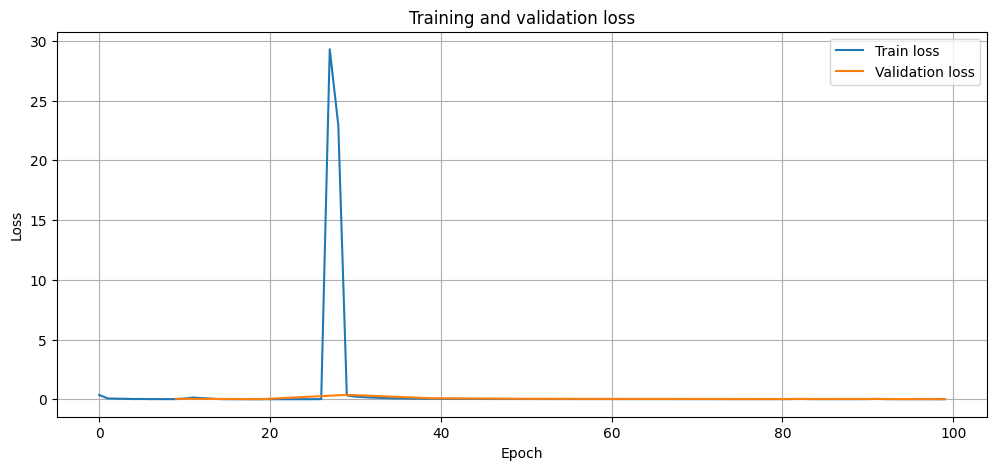

In [79]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(train_loss, label="Train loss")
ax.plot(np.arange(valid_every - 1, epochs, valid_every), valid_loss, label="Validation loss")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.set_title("Training and validation loss")
ax.legend()
ax.grid()
plt.show()

In [48]:
class DeepKoopman(nn.Module):

    def __init__(self, autoencoder, learn_A=False) -> None:
        super().__init__()
        
        self.autoencoder = autoencoder
        self.latent_dim = autoencoder.latent_dim
        self.learn_A = learn_A

        if learn_A:
            self.A = nn.Linear(self.latent_dim, self.latent_dim, bias=False) # shape (d, d)
        else:
            self.register_buffer("A", torch.empty(self.latent_dim, self.latent_dim)) # shape (d, d)

        self.B = nn.Linear(3, self.latent_dim, bias=False) # shape (n_magnetization, d)


    def compute_linear_operator_pinv(self, Xtilde, Ytilde) -> None:
        A = torch.linalg.pinv(Xtilde, rcond=1e-4) @ Ytilde
        self.A.data.copy_(A)
    

    def compute_linear_operator_tikh(self, Xtilde, Ytilde, lam=1e-1) -> None:
    # Xtilde: (n, d), Ytilde: (n, d)
        XtX = Xtilde.T @ Xtilde             # (d, d)
        d   = XtX.shape[0]
        reg = lam * torch.eye(d, device=XtX.device)
        A   = torch.linalg.solve(XtX + reg, Xtilde.T @ Ytilde)
        self.A.data.copy_(A)


    def forward(self, X, Y, U) -> tuple[torch.Tensor, torch.Tensor]:
        '''
        params:
        X: input data (n x m)
        Y: target data (n x m)
        U: external effect (n x 3)
        '''
        T = X.shape[0]
        T_half = T // 2
        Xtilde = self.autoencoder.encode(X)    # encode X: (n x m)  -> Xtilde: (n x d)
        Ytilde = self.autoencoder.encode(Y)    # encode Y: (n x m)  -> Ytilde: (n x d)

        ext_effect = self.B(U[:T_half, :])  # shape (n//2 x d)

        # compute linear operator according to 
        # A = (Ytilde - B @ U) @ Xtilde^+
        if not self.learn_A:
            self.compute_linear_operator_tikh(
                Xtilde[:T_half,:], Ytilde[:T_half,:] - ext_effect
                )

            Ytilde_pred_list = [Xtilde[0] @ self.A + self.B(U[0,:])] 
            for t in range(1, T):
                next_pred = Ytilde_pred_list[t-1] @ self.A + self.B(U[t,:])
                Ytilde_pred_list.append(next_pred)
        else:
            Ytilde_pred_list = [self.A(Xtilde[0]) + self.B(U[0,:])] 
            for t in range(1, T):
                next_pred = self.A(Ytilde_pred_list[-1]) + self.B(U[t,:])
                Ytilde_pred_list.append(next_pred)
        
        Ytilde_pred = torch.stack(Ytilde_pred_list, dim=0)
        
        Xhat = self.autoencoder.decode(Xtilde)
        Yhat = self.autoencoder.decode(Ytilde_pred)

        return Xhat, Yhat
    
    
    def predict(self, X, T, U) -> torch.Tensor:
        if len(X.shape) == 1:
            X = X.unsqueeze(0)  # make it (1, input_dim)

        with torch.no_grad():
            Xtilde0 = self.autoencoder.encode(X)    # encode X: (n x m)  -> Xtilde: (n x d)
            Ytilde_pred = torch.zeros((T, Xtilde0.shape[1])).to(Xtilde0.device)

            # If A is computed using pseudo-inverse or tikhonov regularization:
            if not self.learn_A:
                Ytilde_pred[0] = Xtilde0 @ self.A + self.B(U[0,:])
                for t in range(1, T):
                    Ytilde_pred[t] = Ytilde_pred[t-1] @ self.A + self.B(U[t,:])

            # If A is learned as a parameter:
            else:
                Ytilde_pred[0] = self.A(Xtilde0) + self.B(U[0,:])
                for t in range(1, T):
                    Ytilde_pred[t] = self.A(Ytilde_pred[t-1]) + self.B(U[t,:])
  
            Yhat = self.autoencoder.decode(Ytilde_pred)
        return Yhat

In [61]:
LEARN_A = True

koopman = DeepKoopman(autoencoder=ae,  
                    learn_A=LEARN_A).to(device)

criterion = nn.MSELoss()

In [62]:
dummy_data1 = torch.ones((50, 3, 36, 9)).to(device)
dummy_data2 = torch.ones((50, 3, 36, 9)).to(device)
dummy_data3 = torch.ones((50, 3)).to(device)

x_dummy, y_dummy = koopman(dummy_data1, dummy_data2, dummy_data3)
x_dummy.shape, y_dummy.shape

(torch.Size([50, 3, 40, 16]), torch.Size([50, 3, 40, 16]))

In [63]:
PRETRAIN_AE = True
if PRETRAIN_AE:
    koopman.autoencoder.load_state_dict(torch.load(datapath / "ae_weights.pth", weights_only=True))

optimizer = optim.Adam(koopman.parameters(), lr=1e-3)

epochs = 100
valid_every = 10
n_rep = 1

train_loss = np.zeros(epochs)
valid_loss = []

for epoch in range(epochs):

    running_loss = 0.0
    for batch in range(train_size):
        for _ in range(n_rep):
            xtrain = Xtrain[batch].to(device)
            ytrain = Ytrain[batch].to(device)
            U = Htrain[batch].to(device)

            koopman.train()
            optimizer.zero_grad()

            xhat, yhat = koopman(xtrain, ytrain, U=U)

            loss = criterion(xhat, xtrain) + criterion(yhat, ytrain)

            loss.backward()
            optimizer.step()
            
        running_loss += loss.item()
    
    train_loss[epoch] = running_loss / n_seq

    if epoch % valid_every == valid_every - 1:
        koopman.eval()
        with torch.no_grad():
            running_loss_val = 0.0
            for batch in range(test_size):
                xtest = Xtest[batch].to(device)
                ytest = Ytest[batch].to(device)
                U = Htest[batch].to(device)

                xhat, yhat = koopman(xtest, ytest, U=U)

                v_loss = criterion(xhat, xtest) + criterion(yhat, ytest)
                running_loss_val += v_loss.item()
            valid_loss.append(running_loss_val / test_size)
        print(f"Epoch {epoch+1}, Training loss: {train_loss[epoch]:.4f}, Validation Loss: {valid_loss[-1]:.4f}")

Epoch 10, Training loss: 0.0762, Validation Loss: 0.1803
Epoch 20, Training loss: 0.0222, Validation Loss: 0.1558
Epoch 30, Training loss: 0.0203, Validation Loss: 0.1548
Epoch 40, Training loss: 0.0204, Validation Loss: 0.1507
Epoch 50, Training loss: 0.0180, Validation Loss: 0.1512
Epoch 60, Training loss: 0.3076, Validation Loss: 0.4135
Epoch 70, Training loss: 0.0729, Validation Loss: 0.2929
Epoch 80, Training loss: 0.0500, Validation Loss: 0.2586
Epoch 90, Training loss: 0.0384, Validation Loss: 0.2407
Epoch 100, Training loss: 0.0323, Validation Loss: 0.2245


In [65]:
koopman.eval()
Ypreds = []
for i in range(test_size):
    xtest = Xtest[i,0,:,:,:].unsqueeze(0).to(device)
    U = Htest[i].to(device)
    yhat = koopman.predict(xtest, T=n_tsteps-1, U=U)
    Ypreds.append(yhat.cpu().numpy())

Ypreds = np.array(Ypreds)
Ypreds = np.permute_dims(Ypreds, (0, 1, 3, 4, 2))


Field 0:
[-3.9492762 31.602274   0.       ]


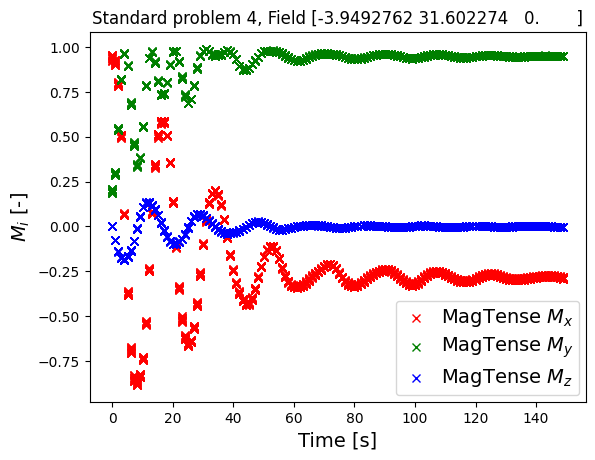

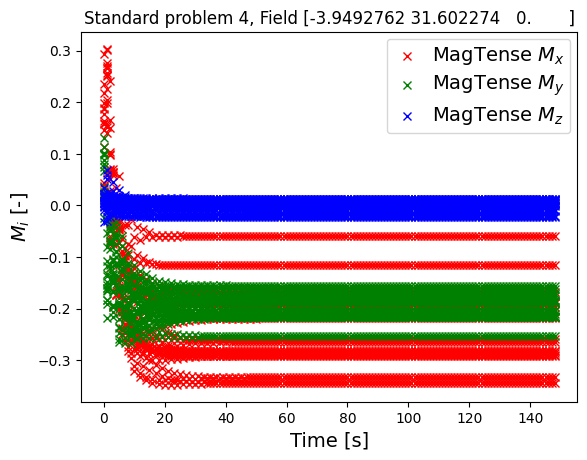

In [67]:
field_idx = 0
print(f"\nField {field_idx}:\n{Hs[field_idx]}")
plot_dynamics(
    np.arange(DATA[field_idx].shape[0]),
    DATA[field_idx],
    field=Hs[field_idx],
)
plot_dynamics(
    np.arange(Ypreds[field_idx].shape[0]),
    Ypreds[field_idx],
    field=Hs[field_idx],
)